In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

## 1. Load data

In [8]:
well_data = gpd.read_file('./data/output/well_city_crash.geojson')
well_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12291 entries, 0 to 12290
Data columns (total 71 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   OBJECTID                   12291 non-null  int32   
 1   advisorySpeed              151 non-null    float64 
 2   areaUnitID                 12291 non-null  int32   
 3   bicycle                    12291 non-null  float64 
 4   bridge                     4979 non-null   float64 
 5   bus                        12291 non-null  float64 
 6   carStationWagon            12291 non-null  float64 
 7   cliffBank                  4979 non-null   float64 
 8   crashDirectionDescription  12291 non-null  object  
 9   crashFinancialYear         12291 non-null  object  
 10  crashLocation1             12291 non-null  object  
 11  crashLocation2             12254 non-null  object  
 12  crashRoadSideRoad          0 non-null      object  
 13  crashSeverity          

In [10]:
alcohol_data = pd.read_csv('./data/crash_near_alcohol_store.csv').loc[:, ['OBJECTID', 'distance_to_store_km']]
alcohol_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30464 entries, 0 to 30463
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   OBJECTID              30464 non-null  int64  
 1   distance_to_store_km  30464 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 476.1 KB


In [11]:
well_data = pd.merge(well_data, alcohol_data, on='OBJECTID', how='left')
well_data.head()

,OBJECTID,advisorySpeed,areaUnitID,bicycle,bridge,bus,carStationWagon,cliffBank,crashDirectionDescription,crashFinancialYear,...,truck,unknownVehicleType,urban,vanOrUtility,vehicle,waterRiver,weatherA,weatherB,geometry,distance_to_store_km
0,66388986,NaN,575300,0.0,0.0,0.0,1.0,1.0,South,2018/2019,...,0.0,0.0,Urban,0.0,0.0,0.0,Light rain,Null,POINT (174.7576 -41.28854),0.549368
1,66388998,NaN,572600,0.0,0.0,0.0,2.0,0.0,North,2017/2018,...,0.0,0.0,Urban,0.0,0.0,0.0,Fine,Null,POINT (174.82511 -41.16802),1.324634
2,66389034,NaN,577000,0.0,NaN,0.0,1.0,NaN,South,2019/2020,...,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null,POINT (174.81144 -41.3266),1.722258
3,66389036,NaN,576800,0.0,NaN,0.0,0.0,NaN,East,2018/2019,...,0.0,0.0,Urban,1.0,NaN,NaN,Light rain,Null,POINT (174.79145 -41.30418),1.231369
4,66389128,NaN,572900,0.0,NaN,0.0,2.0,NaN,Null,2017/2018,...,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null,POINT (174.77253 -41.27599),2.240868


In [12]:
target_cols = ['crashSeverity', 'flatHill', 'intersection', 'light','roadSurface', 'speedLimit', 'weatherA', 'weatherB','distance_to_store_km','geometry']
df = well_data[target_cols]
df.head()

,crashSeverity,flatHill,intersection,light,roadSurface,speedLimit,weatherA,weatherB,distance_to_store_km,geometry
0,Non-Injury Crash,Hill Road,None,Overcast,Sealed,50.0,Light rain,Null,0.549368,POINT (174.7576 -41.28854)
1,Non-Injury Crash,Flat,None,Dark,Sealed,50.0,Fine,Null,1.324634,POINT (174.82511 -41.16802)
2,Minor Crash,Flat,None,Overcast,Sealed,20.0,Fine,Null,1.722258,POINT (174.81144 -41.3266)
3,Non-Injury Crash,Flat,None,Overcast,Sealed,50.0,Light rain,Null,1.231369,POINT (174.79145 -41.30418)
4,Non-Injury Crash,Flat,None,Dark,Sealed,50.0,Fine,Null,2.240868,POINT (174.77253 -41.27599)


## 2. Check class balance and choosing resampling Method

In [13]:
# Check the distribution of crashSeverity
severity_counts = df['crashSeverity'].value_counts()
print(severity_counts)

crashSeverity
Non-Injury Crash    9031
Minor Crash         2671
Serious Crash        562
Fatal Crash           27
Name: count, dtype: int64


In [14]:
# Calculate the ratio of class 0 and class 1
class_0_count = severity_counts.get('Non-Injury Crash', 0)
class_1_count = severity_counts.get('Serious Crash', 0) + severity_counts.get('Fatal Crash', 0)

ratio = class_0_count / class_1_count if class_1_count > 0 else np.inf
print(f'Ratio of class 0 to class 1: {ratio:.2f}')

Ratio of class 0 to class 1: 15.33


In [34]:
# Downsample class 0 to achieve a 4:1 ratio
desired_class_0_count = 4 * class_1_count
class_0_samples = df[df['crashSeverity'] == 'Non-Injury Crash'].sample(n=desired_class_0_count, random_state=42)

# Combine the downsampled class 0 with class 1
class_1_samples = df[df['crashSeverity'].isin(['Serious Crash', 'Fatal Crash'])]
balanced_df = pd.concat([class_0_samples, class_1_samples])

# Shuffle the resulting DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_df['target'] = balanced_df['crashSeverity'].apply(lambda x: 0 if x == 'Non-Injury Crash' else 1)
target_counts = balanced_df['target'].value_counts()
print(target_counts)

balanced_ratio = target_counts[0] / target_counts[1]
print(f'Ratio of class 0 to class 1 after balancing: {balanced_ratio:.2f}')

target
0    2356
1     589
Name: count, dtype: int64
Ratio of class 0 to class 1 after balancing: 4.00


## 3. EDA and data cleaning

In [35]:
missing_percentage = balanced_df.isnull().mean() * 100

# Display the percentage of missing values for each column
print(missing_percentage)

crashSeverity             0.000000
flatHill                  0.000000
intersection            100.000000
light                     0.000000
roadSurface               0.000000
speedLimit                0.848896
weatherA                  0.000000
weatherB                  0.000000
distance_to_store_km      0.000000
geometry                  0.000000
target                    0.000000
dtype: float64


In [36]:
balanced_df['speed_cat'] = pd.cut(balanced_df['speedLimit'], bins=[0, 30, 50 ,80, 200], labels=['low', 'mid', 'mid-high', 'high'])
balanced_df['speed_cat'].value_counts()

,count
speed_cat,
mid,2109
high,355
low,228
mid-high,228


<ipython-input-18-102523b83da8>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-18-102523b83da8>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-18-102523b83da8>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-18-102523b83da8>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-18-102523b83da8>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-18-102523b83da8>:21: UserWarning: FixedF

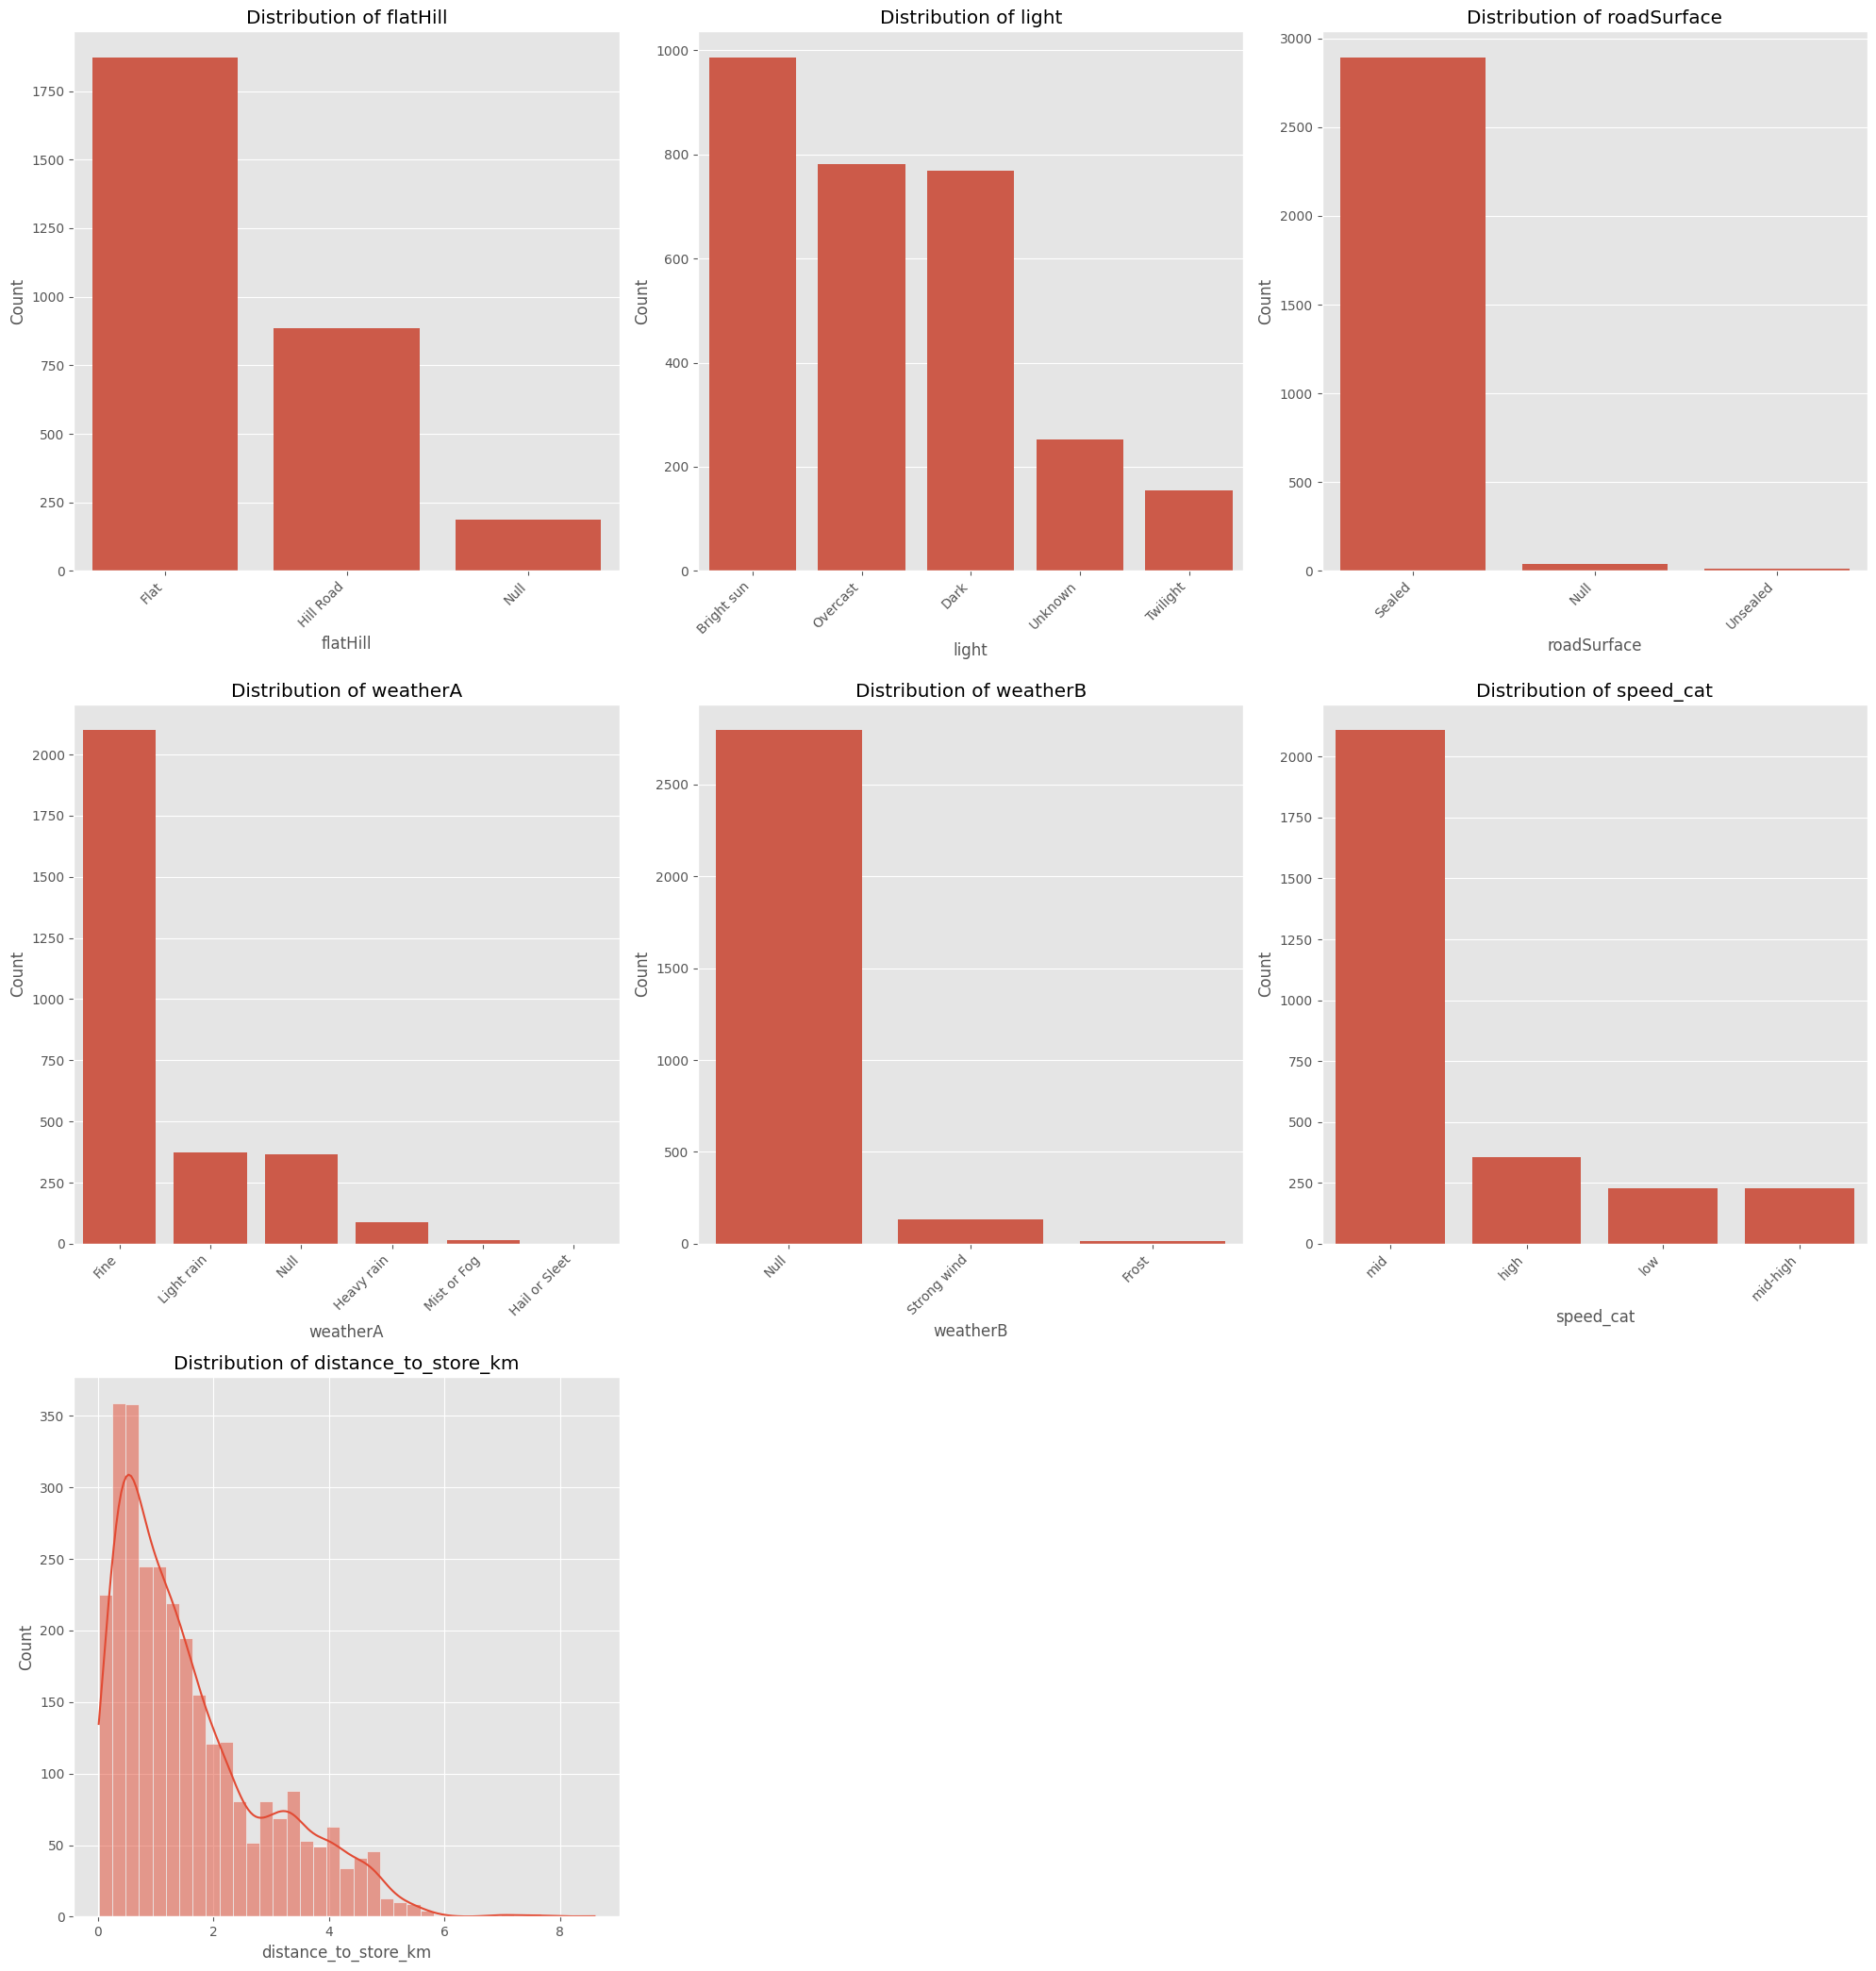

In [18]:
## check distribution of variables
import matplotlib.pyplot as plt
import seaborn as sns

balanced_df = balanced_df.drop(columns=['crashSeverity','intersection', 'speedLimit'])
# Separate categorical and numeric columns
categorical_columns = balanced_df.select_dtypes(include=['object', 'category']).columns
numeric_columns = ['distance_to_store_km']

# Calculate total number of subplots
total_plots = len(categorical_columns) + len(numeric_columns)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=(total_plots + 2) // 3, ncols=3, figsize=(20, 7 * ((total_plots + 2) // 3)))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Plot distributions for categorical features
for i, col in enumerate(categorical_columns):
    sns.countplot(data=balanced_df, x=col, order=balanced_df[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Plot distributions for numeric features
for i, col in enumerate(numeric_columns, start=len(categorical_columns)):
    sns.histplot(data=balanced_df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Remove any unused subplots
for i in range(total_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [19]:
# Change the data type of speed_cat to object
balanced_df['speed_cat'] = balanced_df['speed_cat'].astype(object)

# Replace string "Null" with "unknown"
balanced_df.replace("Null", "unknown", inplace=True)

# Fill all null values with "unknown"
balanced_df.fillna("unknown", inplace=True)

# Display the updated DataFrame to verify the changes
print(balanced_df.head())

    flatHill       light roadSurface weatherA weatherB  distance_to_store_km  \
0       Flat     Unknown      Sealed  unknown  unknown              1.030812   
1       Flat  Bright sun      Sealed     Fine  unknown              0.548708   
2  Hill Road        Dark      Sealed     Fine  unknown              1.276655   
3       Flat    Overcast      Sealed     Fine  unknown              0.217419   
4       Flat        Dark      Sealed     Fine  unknown              0.603413   

                      geometry  target speed_cat  
0  POINT (174.77794 -41.30738)       0       mid  
1  POINT (174.82152 -41.30902)       0       mid  
2  POINT (174.81419 -41.17665)       0       mid  
3  POINT (174.77406 -41.29625)       0       mid  
4  POINT (174.78117 -41.29343)       1       mid  


In [20]:
# Get detailed statistics for object columns
object_columns = balanced_df.select_dtypes(include=['object']).columns

detailed_stats = {}

for col in object_columns:
    top_value_count = balanced_df[col].value_counts().iloc[0]
    total_count = balanced_df[col].count()  # Total non-null count
    unknown_count = (balanced_df[col] == 'unknown').sum()

    detailed_stats[col] = {
        'unique_values': balanced_df[col].nunique(),
        'top_value': balanced_df[col].mode()[0],
        'top_value_count': top_value_count,
        'top_value_percentage': (top_value_count / total_count) * 100 if total_count > 0 else 0,
        'missing_values': balanced_df[col].isnull().sum(),
        'unknown_count': (balanced_df[col] == 'unknown').sum(),
        'unknown_percentage': (unknown_count / total_count) * 100 if total_count > 0 else 0
    }

# Convert the detailed statistics to a DataFrame for better readability
detailed_stats_df = pd.DataFrame(detailed_stats).T
detailed_stats_df.columns = ['Unique Values', 'Top Value', 'Top Value Count', 'Top Value Percentage', 'Missing Values', 'Unknown Count', 'Unknown Percentage']

# Display the detailed statistics
detailed_stats_df

,Unique Values,Top Value,Top Value Count,Top Value Percentage,Missing Values,Unknown Count,Unknown Percentage
flatHill,3,Flat,1874,63.633277,0,186,6.315789
light,5,Bright sun,987,33.514431,0,0,0.0
roadSurface,3,Sealed,2895,98.302207,0,40,1.358234
weatherA,6,Fine,2100,71.307301,0,367,12.4618
weatherB,3,unknown,2796,94.940577,0,2796,94.940577
speed_cat,5,mid,2109,71.612903,0,25,0.848896


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming balanced_df is your DataFrame and 'target' is the dependent variable
target = 'target'  # Dependent variable

# List of categorical variables to analyze
categorical_vars = ['flatHill', 'light', 'roadSurface', 'speed_cat', 'weatherA', 'weatherB']  # Replace with your actual variable names

# Initialize an empty list to store pivot tables
pivot_tables = []

# Loop through each categorical variable to create pivot tables
for var in categorical_vars:
    # Create a pivot table for the current variable
    pivot_table = pd.crosstab(balanced_df[var], balanced_df[target], margins=False)
    # Add a Total column for reference
    pivot_table['Total'] = pivot_table.sum(axis=1)

    # Calculate percentages
    pivot_table['0%'] = round(pivot_table[0] / pivot_table['Total'] * 100,2)
    pivot_table['1%'] = round(pivot_table[1] / pivot_table['Total'] * 100,2)

    # Append the pivot table to the list
    pivot_tables.append(pivot_table)

# Concatenate all pivot tables into a single DataFrame
comprehensive_table = pd.concat(pivot_tables, keys=categorical_vars)

# Display the comprehensive table
print(comprehensive_table)

target                        0    1  Total      0%     1%
flatHill    Flat           1478  396   1874   78.87  21.13
            Hill Road       696  189    885   78.64  21.36
            unknown         182    4    186   97.85   2.15
light       Bright sun      745  242    987   75.48  24.52
            Dark            597  172    769   77.63  22.37
            Overcast        636  146    782   81.33  18.67
            Twilight        125   29    154   81.17  18.83
            Unknown         253    0    253  100.00   0.00
roadSurface Sealed         2310  585   2895   79.79  20.21
            Unsealed          6    4     10   60.00  40.00
            unknown          40    0     40  100.00   0.00
speed_cat   high            283   72    355   79.72  20.28
            low             167   61    228   73.25  26.75
            mid            1711  398   2109   81.13  18.87
            mid-high        173   55    228   75.88  24.12
            unknown          22    3     25   88.00  12.

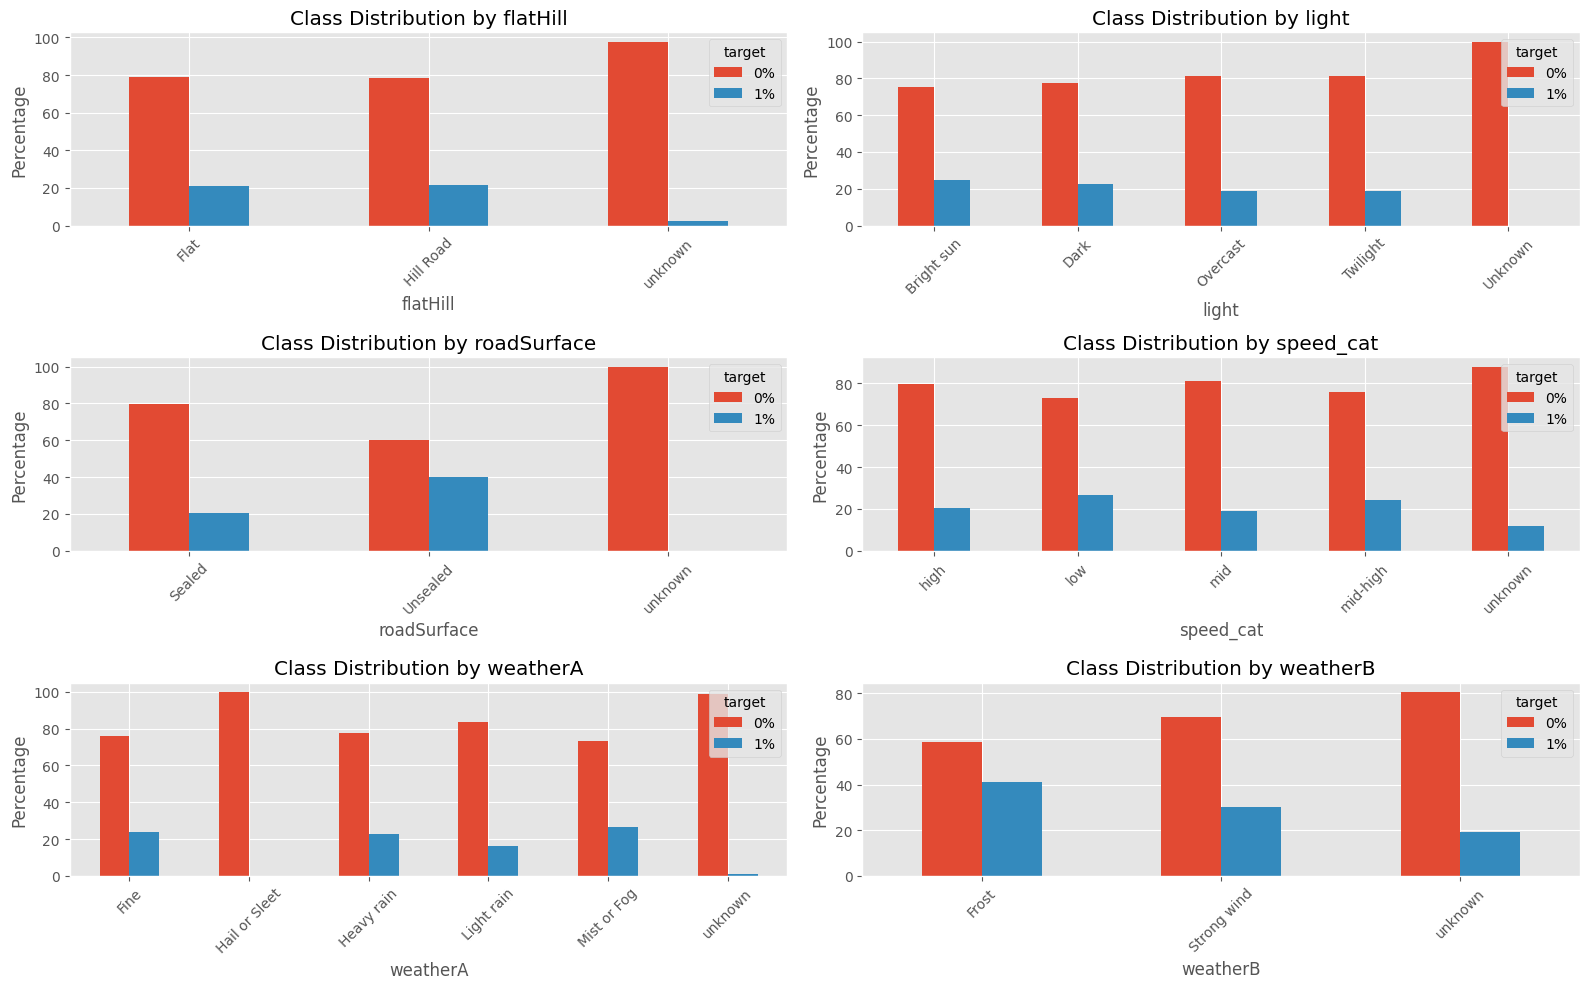

In [22]:
plot_df = comprehensive_table.reset_index()

# Create subplots for each categorical variable
num_vars = len(categorical_vars)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,10))
# Define colors for the classes
# colors = ['lightblue', 'lightcoral']  # Blue for class 0, Red for class 1

for ax, col in zip(axes.flatten(), categorical_vars):
    plot_subset = plot_df[plot_df['level_0'] == col][['level_1', '0%', '1%']].set_index('level_1')
    plot_subset.plot(kind='bar', stacked=False, ax=ax) # , color=colors,
    ax.set_title(f'Class Distribution by {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Percentage')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='target')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

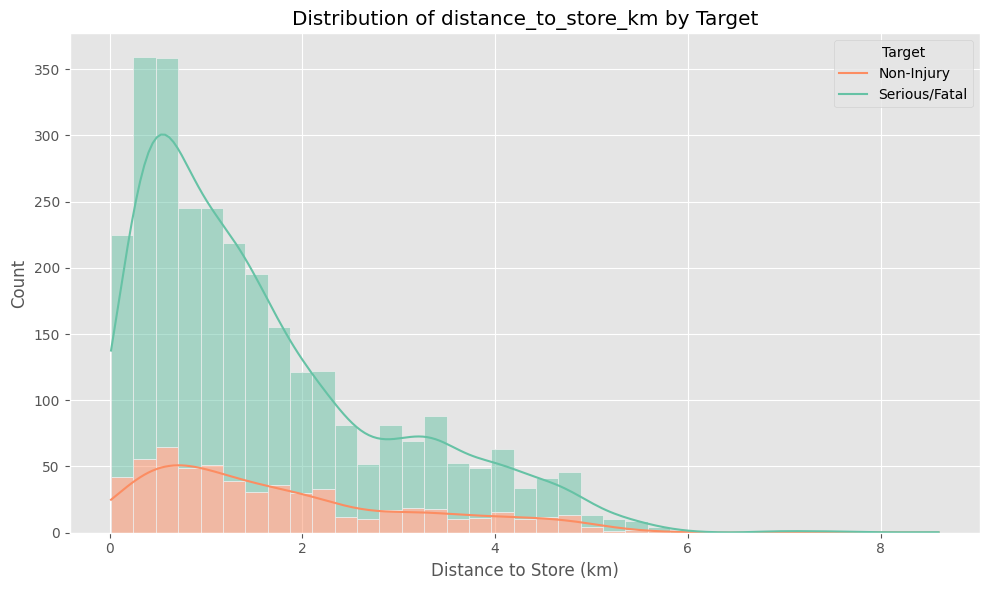

In [23]:
# Add plot for distance_to_store_km distribution by target
fig, axes = plt.subplots(figsize=(10, 6))

sns.histplot(data=balanced_df, x='distance_to_store_km', hue='target', kde=True,
             multiple="stack", palette="Set2", ax=axes)
axes.set_title('Distribution of distance_to_store_km by Target')
axes.set_xlabel('Distance to Store (km)')
axes.set_ylabel('Count')
axes.legend(title='Target', labels=['Non-Injury', 'Serious/Fatal'])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## 4. Modeling

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm

# Define feature columns and target
feature_cols = ['flatHill', 'light', 'roadSurface', 'speed_cat', 'weatherA', 'weatherB', 'distance_to_store_km']
target = 'target'

# Prepare the features and target
X = balanced_df[feature_cols]  # Features
y = balanced_df[target]  # Target

# One-Hot Encode the features
X_encoded = pd.get_dummies(X, columns=categorical_vars)

# Specify the columns you want to drop
columns_to_drop = ['flatHill_Flat', 'light_Bright sun', 'roadSurface_Unsealed', 'weatherA_Fine', 'weatherB_unknown','speed_cat_low']  # Example columns to drop

# Drop the specified columns
X_encoded = X_encoded.drop(columns=columns_to_drop, errors='ignore')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [25]:
X_train.columns

Index(['distance_to_store_km', 'flatHill_Hill Road', 'flatHill_unknown',
       'light_Dark', 'light_Overcast', 'light_Twilight', 'light_Unknown',
       'roadSurface_Sealed', 'roadSurface_unknown', 'speed_cat_high',
       'speed_cat_mid', 'speed_cat_mid-high', 'speed_cat_unknown',
       'weatherA_Hail or Sleet', 'weatherA_Heavy rain', 'weatherA_Light rain',
       'weatherA_Mist or Fog', 'weatherA_unknown', 'weatherB_Frost',
       'weatherB_Strong wind'],
      dtype='object')

In [26]:
# Define and fit the Logistic Regression model without regularization (penalty='none')
model = LogisticRegression(max_iter=5000, solver='newton-cg') # newton-cg is suitable for no penalty
model.fit(X_train, y_train)

# Fit the model using statsmodels for summary
X_train_sm = sm.add_constant(X_train)  # Add constant for intercept
# Ensure all columns in X_train_sm are numeric
X_train_sm = X_train_sm.astype(float)  # This line converts all columns to float type
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Print the summary
print(result.summary())

# Evaluate the model on the test set using AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f'Test Set AUC: {auc_score:.2f}')

         Current function value: 0.466506
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 2356
Model:                          Logit   Df Residuals:                     2335
Method:                           MLE   Df Model:                           20
Date:                Sun, 13 Oct 2024   Pseudo R-squ.:                 0.07509
Time:                        04:25:41   Log-Likelihood:                -1099.1
converged:                      False   LL-Null:                       -1188.3
Covariance Type:            nonrobust   LLR p-value:                 1.950e-27
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0141      0.785     -0.018      0.986      -1.553       1.525
distance_to_store_km       0.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Understanding the pseudo R²
1) McFadden's R²
The default pseudo R² is McFadden's R² which is suggests that the model explains 7% of the variance in the outcome variable compared to a model with no predictors. And it's generally much lower than traditional R².  
2) Nagelkerke's R²
- Like other pseudo-R² measures, it doesn't have the same straightforward interpretation as R² in linear regression.
- It tends to be lower than the R² values you might expect in linear regression.


In [27]:
llf = -1099.1  # Log-likelihood of the full model
llnull = -1188.3  # Log-likelihood of the null model
n = 2356  # Number of observations

r2_cox_snell = 1 - np.exp((2/n) * (llnull - llf))
r2_nagelkerke = r2_cox_snell / (1 - np.exp((2/n) * llnull))

print(f"\nNagelkerke's R²: {r2_nagelkerke:.4f}")


Nagelkerke's R²: 0.1148


## 6. Check residual autocorrelation

In [62]:
import numpy as np
from scipy.special import xlogy

def deviance_residuals(y_true, y_pred_proba):
    # Clip probabilities to avoid log(0) or log(1)
    eps = 1e-15
    y_pred_proba = np.clip(y_pred_proba, eps, 1 - eps)

    # Calculate deviance residuals
    dev_resid = np.sqrt(2) * np.sqrt(
        xlogy(y_true, y_true / y_pred_proba) +
        xlogy(1 - y_true, (1 - y_true) / (1 - y_pred_proba))
    )

    # Assign sign
    dev_resid *= np.where(y_true > y_pred_proba, 1, -1)

    return dev_resid


deviance_residuals = deviance_residuals(y, y_pred_proba)

len(deviance_residuals)

2945

In [65]:
resid_df = balanced_df.iloc[y.index].copy()

# Add the deviance residuals to this DataFrame
resid_df['deviance_residuals'] = deviance_residuals

# Convert to GeoDataFrame
gdf_residuals = gpd.GeoDataFrame(resid_df[['deviance_residuals', 'geometry']], geometry='geometry', crs=balanced_df.crs)
gdf_residuals

,deviance_residuals,geometry
0,-0.115263,POINT (174.77794 -41.30738)
1,-0.713114,POINT (174.82152 -41.30902)
2,-0.717877,POINT (174.81419 -41.17665)
3,-0.600646,POINT (174.77406 -41.29625)
4,1.779106,POINT (174.78117 -41.29343)
...,...,...
2940,-0.898331,POINT (174.7855 -41.2668)
2941,-0.700303,POINT (174.83916 -41.15545)
2942,-0.731501,POINT (174.77408 -41.30187)
2943,-0.645015,POINT (174.80866 -41.23261)


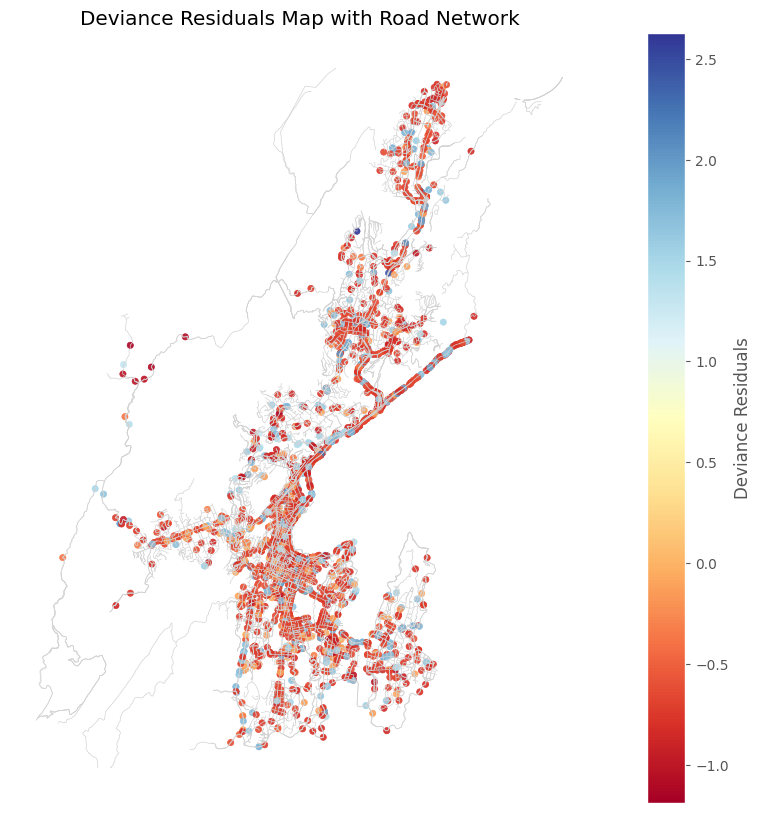

In [66]:
# Load the road map data
road_map = gpd.read_file('./well_city_road.geojson')

# Plot the residuals on a map with the road network as a base layer
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the road network first
road_map.plot(ax=ax, color='lightgrey', linewidth=0.5)

# Plot the residuals on top of the road network
gdf_residuals.plot(column='deviance_residuals', cmap='RdYlBu', legend=True,
                   legend_kwds={'label': 'Deviance Residuals'}, ax=ax,
                   markersize=20, alpha=0.9)

ax.set_title('Deviance Residuals Map with Road Network')
plt.axis('off')
plt.show()

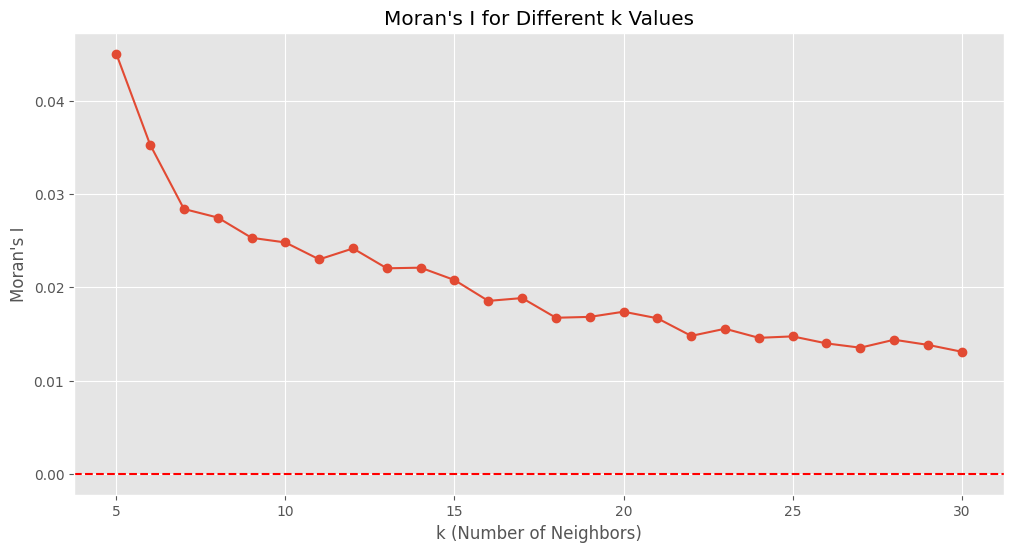

Significant Moran's I values:
k=5: Moran's I=0.0451, p-value=0.0010
k=6: Moran's I=0.0353, p-value=0.0010
k=7: Moran's I=0.0284, p-value=0.0040
k=8: Moran's I=0.0275, p-value=0.0020
k=9: Moran's I=0.0253, p-value=0.0010
k=10: Moran's I=0.0248, p-value=0.0020
k=11: Moran's I=0.0230, p-value=0.0030
k=12: Moran's I=0.0242, p-value=0.0010
k=13: Moran's I=0.0220, p-value=0.0040
k=14: Moran's I=0.0221, p-value=0.0010
k=15: Moran's I=0.0208, p-value=0.0020
k=16: Moran's I=0.0185, p-value=0.0030
k=17: Moran's I=0.0189, p-value=0.0030
k=18: Moran's I=0.0167, p-value=0.0040
k=19: Moran's I=0.0168, p-value=0.0030
k=20: Moran's I=0.0174, p-value=0.0030
k=21: Moran's I=0.0167, p-value=0.0020
k=22: Moran's I=0.0148, p-value=0.0040
k=23: Moran's I=0.0156, p-value=0.0030
k=24: Moran's I=0.0146, p-value=0.0030
k=25: Moran's I=0.0147, p-value=0.0040
k=26: Moran's I=0.0140, p-value=0.0040
k=27: Moran's I=0.0135, p-value=0.0010
k=28: Moran's I=0.0144, p-value=0.0040
k=29: Moran's I=0.0138, p-value=0.0050


In [70]:
from libpysal.weights import KNN
from esda.moran import Moran
import matplotlib.pyplot as plt

# Function to calculate Moran's I for different k values
def calculate_morans_i(gdf, column, max_k):
    results = []
    for k in range(5, max_k + 1):
        knn = KNN.from_dataframe(gdf, k=k)
        moran = Moran(gdf[column], knn)
        results.append((k, moran.I, moran.p_sim))
    return results

# Calculate Moran's I for different k values
max_k = 30  # You can adjust this value
moran_results = calculate_morans_i(gdf_residuals, 'deviance_residuals', max_k)

# Plot the results
k_values, moran_i, p_values = zip(*moran_results)
plt.figure(figsize=(12, 6))
plt.plot(k_values, moran_i, marker='o')
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Moran's I for Different k Values")
plt.xlabel('k (Number of Neighbors)')
plt.ylabel("Moran's I")
plt.show()

# Print results for significant Moran's I values
print("Significant Moran's I values:")
for k, i, p in moran_results:
    if p < 0.05:
        print(f"k={k}: Moran's I={i:.4f}, p-value={p:.4f}")